# 02: Meshes

Meshing is the process to create finite elements and to connect those elements to formulate a set of functions. 
Finite elements are created by separating the known geometry with imaginary lines, and the elements are then connected with each other by specifying nodal connectivity at the element boundaries.

Elements must cover all the domain $\Omega$ but no more and must fulfill the following rule: _if two elements have some intersection, it is either a common vertex or a common FULL edge (or edge and face in 3D). In particular, two different elements do not overlap._


Consider the following data structure, we will see together how this represent a mesh in $\mathbb{R}^2$:

In [1]:
import numpy as np

Points           = np.array([ [ 0.0, 0.0 ], [ 1.0, 0.0 ], [ 1.0, 1.0 ], [ 0.0, 1.0 ] ])
ConnectivityList = np.array([ [ 0,1,2 ], [ 2,3,0 ] ])
# you could also set labels

print( Points )
print(' ')
print( ConnectivityList )

[[0. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]]
 
[[0 1 2]
 [2 3 0]]


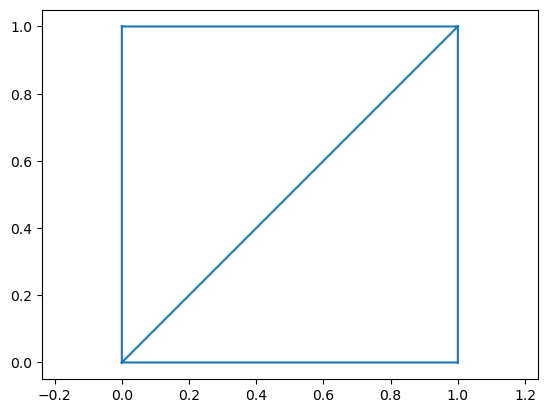

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( Points[:,0], Points[:,1], triangles = ConnectivityList )
plt.show()

Let's make it look more professional now by using the widespread tool ```meshio```.

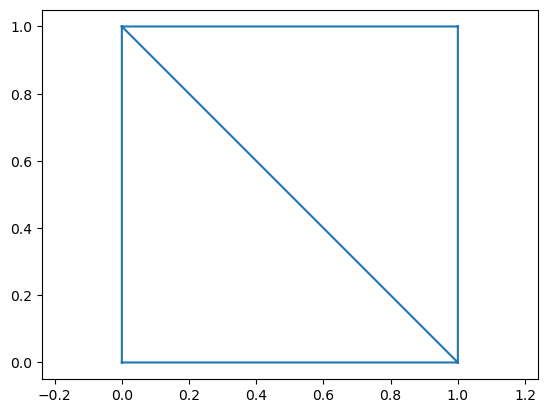

In [3]:
import meshio

mesh = meshio.Mesh(
    points = Points,
    cells  = ConnectivityList,
)

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

Let's see now something funnier. Let's import some pre-saved meshes in vtu format.

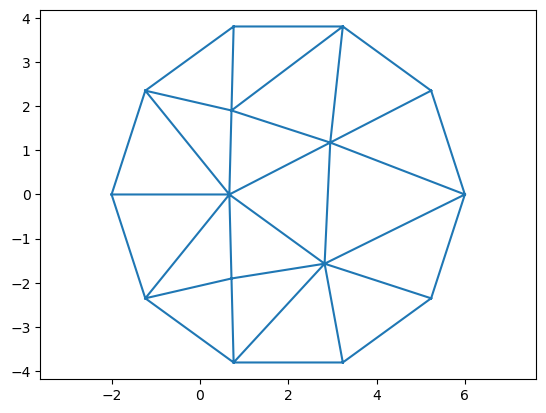

In [4]:
mesh = meshio.read('../mesh-files/circle.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

Disclaimer: when the domain is not polygonal we commit an additional error in approximating the domain with finite elements. 

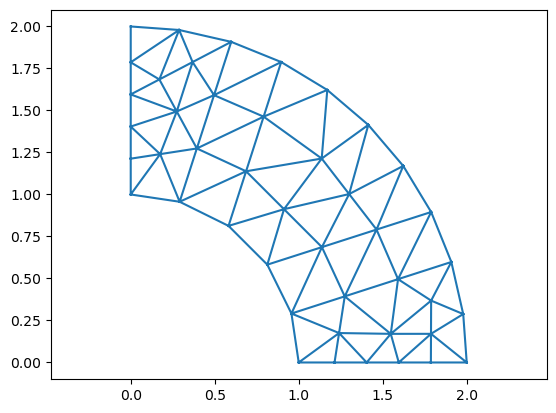

In [7]:
mesh = meshio.read('../mesh-files/crown.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

<IPython.core.display.Javascript object>


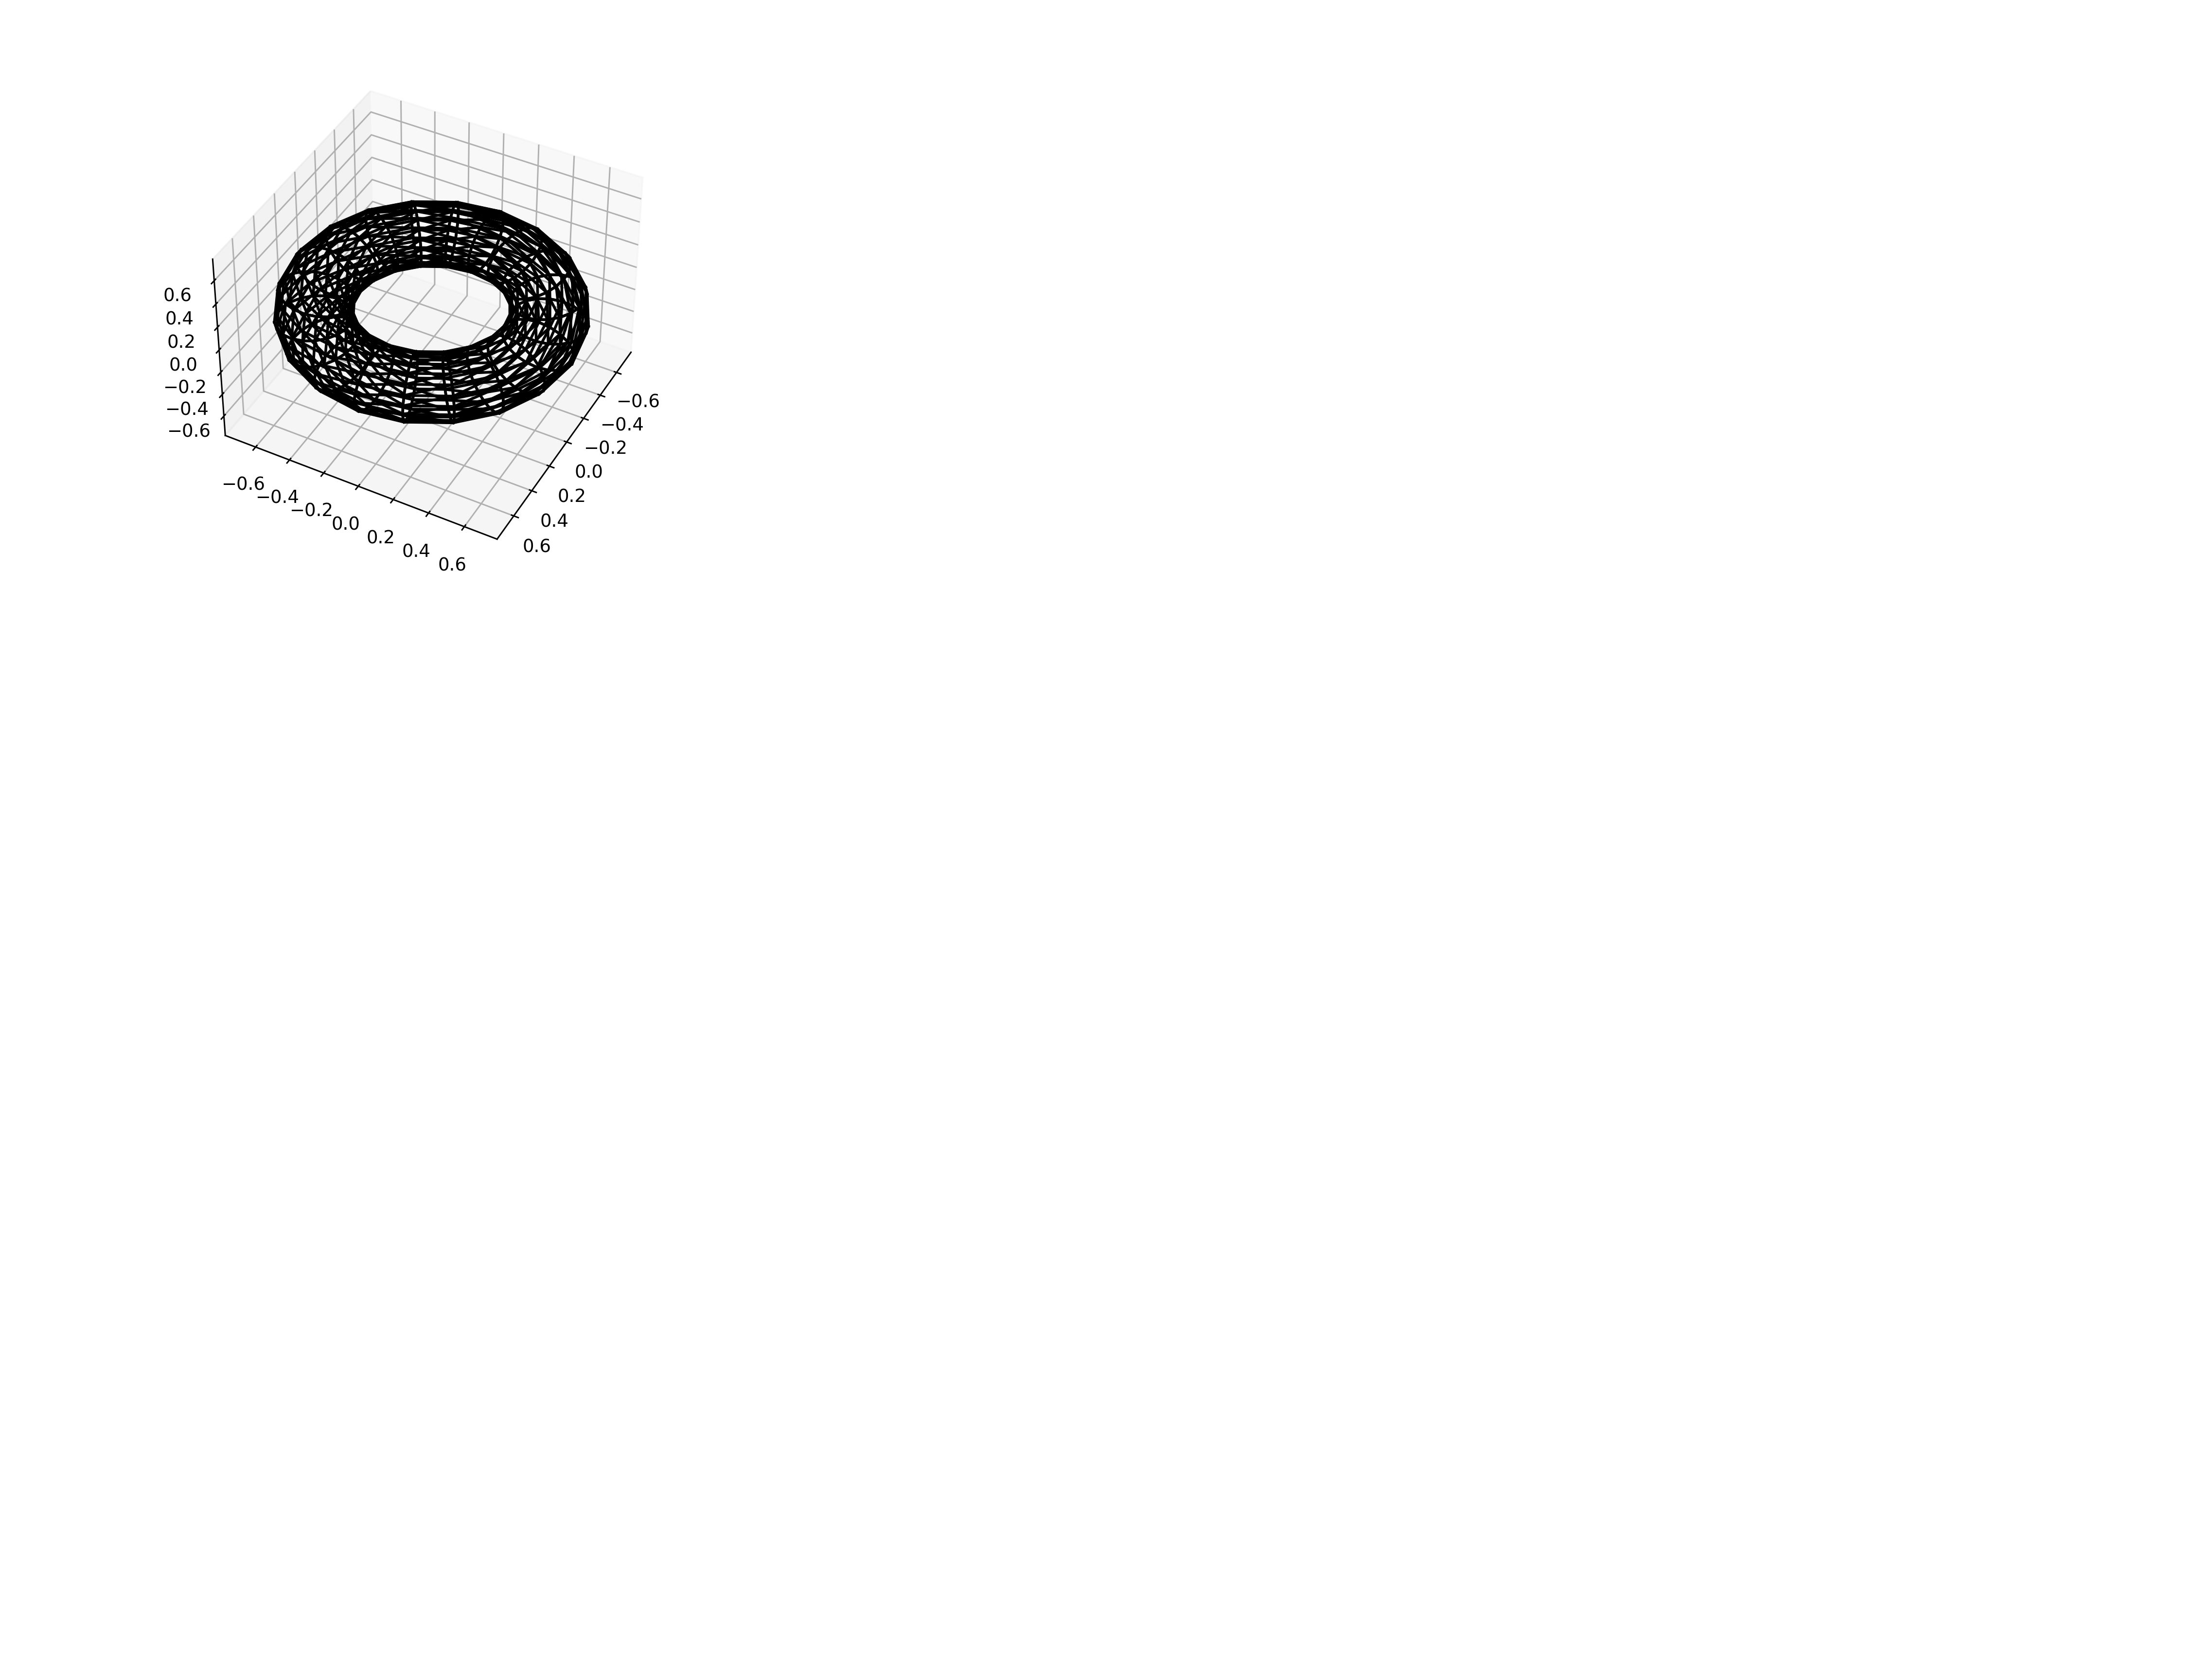

In [20]:
mesh = meshio.read('../mesh-files/torus.vtu')
%matplotlib notebook

fig = plt.figure() 
ax  = fig.add_subplot(111, projection='3d') 
for triangle in mesh.cells[1].data: 
    ax.plot(mesh.points[triangle, 0], mesh.points[triangle, 1], mesh.points[triangle, 2], '-k') 
ax.set_xlim(-.75, .75)
ax.set_ylim(-.75, .75)
ax.set_zlim(-.75, .75)
plt.show()

## PushForward and PullBack operators

Suppose we have much stranger shapes than the ones we've considered and that we are interested in computing their surface/volume.
The simplest idea would be to compute their measure as the sum of the measure of the elements forming the meshes.
Yet, even in the 2D case, this is not trivial, given that the triangles are all translated, rotated, and stretched.

An easy way out of this consists in considering an affine map between a so-called reference element, that is the element with vertices the origin and the canonical vectors $e_1, e_2, \ldots, e_d$ and try somehow to express the measure of the $k$th element (sometimes called physical element) as a function of the affine mapping between the reference element $\hat{K}$ and the physical element $K$.

For sake of simplicity we consider the case $d=2$ and write the _push forward_ operator as
$$
\begin{pmatrix}
x \\ 
y
\end{pmatrix}
=
\underbrace{
\begin{pmatrix}
x_{K,2}-x_{K,1} & x_{K,3}-x_{K,1} \\ 
y_{K,2}-y_{K,1} & y_{K,3}-y_{K,1}
\end{pmatrix}
}_{\text{let's call it $B_K$}}
\begin{pmatrix}
\xi \\
\eta
\end{pmatrix}
+
\begin{pmatrix}
x_{K,1} \\
y_{K,1}
\end{pmatrix}
$$
mapping points from $\hat{K}$ to $K$. This is a bijective operator, its inverse is called _pull back_ and can be written as
$$
\begin{pmatrix}
\xi \\ 
\eta
\end{pmatrix}
=
\begin{pmatrix}
x_{K,2}-x_{K,1} & x_{K,3}-x_{K,1} \\ 
y_{K,2}-y_{K,1} & y_{K,3}-y_{K,1}
\end{pmatrix}^{-1}
\left(
\begin{pmatrix}
x \\
y
\end{pmatrix}
-
\begin{pmatrix}
x_{K,1} \\
y_{K,1}
\end{pmatrix}
\right)
$$.

Denote now the push forward as $F_K$ and the pull back as $F^{-1}_K$. 
Notice that the Jacobian of $F_K$ equals $\det(B_K)$.
The measure of the $k$th element can be computed using a simple change of variable:
$$
\int_{K} 1 \mathrm{d}\mathbf{x}
=
\det(B_K)\int_{\hat{K}} 1 \mathrm{d}\mathbf{\hat{x}}
=
\frac{\det(B_K)}{2}.
$$

The measure of the whole mesh is therefore equal to
$$
\sum_{k=1}^{N} \frac{\det(B_{K_k})}{d!}
$$
where $N$ is the number of elements in the mesh and the 1 over the factorial of $d$ is the measure of the $d$-dimensional unit simplex in $\mathbb{R}^d$ (prove it).

### Example
Let's see that in practice: consider a section of circular crown with inner and outer radii respectively $r=1$ and $R=2$.

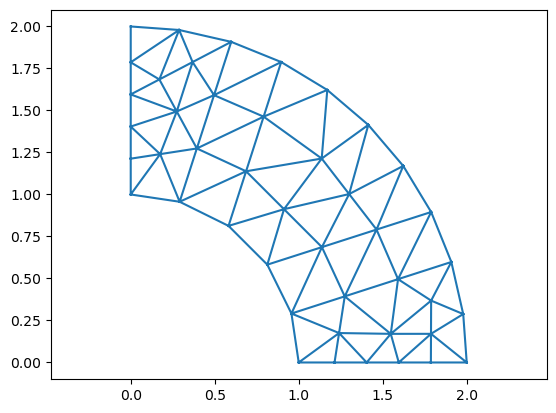

In [9]:
mesh = meshio.read('../mesh-files/crown.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

[[0.5981592 1.9084557]
 [0.288121  1.9791377]]
 
[0.36824983 1.7881716 ]
 
[[ 0.22990936  0.12028408]
 [-0.08012882  0.19096601]]
 
[[ 0.22990936 -0.08012882]
 [ 0.12028408  0.19096601]]


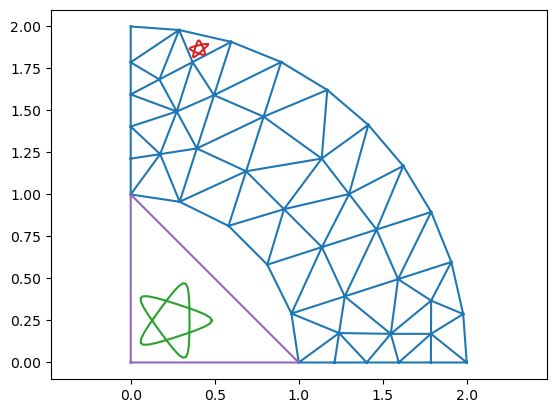

In [14]:
Points = mesh.points[:,:2]  # for sake of brevity (had to set :2 bcause meshio is stupid or something idk)
CList  = mesh.cells[0].data # for sake of brevity

# plot mesh
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )

# draw funny curve in reference element
R = 5
r = 3
d = 5
th = np.linspace( 0, 3 * 2 * np.pi );
x = ( ( R - r ) * np.cos( th ) + d * np.cos( ( R - r ) / r * th ) ) / 30 + 1/4;
y = ( ( R - r ) * np.sin( th ) - d * np.sin( ( R - r ) / r * th ) ) / 30 + 1/4;
plt.plot( x, y )

# choose a physical element and push there the funny curve
k = 12
B = ( Points[CList[k,1:]] - Points[CList[k,0]] ).T

print( Points[CList[k,1:]] )
print(' ')
print( Points[CList[k,0 ]] )
print(' ')
print( Points[CList[k,1:]] - Points[CList[k,0]] )
print(' ')
print( (Points[CList[k,1:]] - Points[CList[k,0]]).T )

pushed = B @ np.vstack((x,y)) + Points[CList[k,0]][:,None]
x = pushed[0,:]
y = pushed[1,:]
plt.plot( x, y )

# plot reference element just because
ref_triangle = np.vstack((np.zeros([1,2]),np.eye(2)))
plt.triplot( ref_triangle[:,0], ref_triangle[:,1], triangles = np.arange(3) )

# now show us
plt.show()

Its measure can be analytically computed:
$$(R^2-r^2)\frac{\pi}{4} = \frac34\pi.$$

The mesh measure is going to closely approximate this value from below (could you say why?).

In [18]:
Points = mesh.points[:,:2]  # for sake of brevity (had to set :2 bcause meshio is stupid or something idk)
CList  = mesh.cells[0].data # for sake of brevity

Nc = CList.shape[0]     # number of cells
d  = CList.shape[1] - 1 # why didn't I simply ask for Points.shape[1]?


# Loop (for kids)
B = np.zeros([Nc,d,d])
dtB = np.zeros([1,d,d])
meas = 0
for k in range( Nc ):
    B[k,:,:] = ( Points[CList[k,1:]] - Points[CList[k,0]] ).T
    meas += np.abs( np.linalg.det( ( Points[CList[k,1:]] - Points[CList[k,0]] ) ) ) / np.math.factorial( d )
dtB = np.linalg.det( B )
print( dtB.shape )

print( meas )
print('Area computed using meshing %0.8e.' % ( np.sum( np.abs( dtB ) ) / np.math.factorial( d ) ) )
print('Area computed analytically  %0.8e.' % ( np.pi * 3 / 4 ) )

(61,)
2.356174858286977
Area computed using meshing 2.35617486e+00.
Area computed analytically  2.35619449e+00.


In [16]:
# Loops are ugly, grownups do it like this
B = np.transpose( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:], ( 0, 2, 1 ) )
print( B.shape )
dtB = np.linalg.det( B )
print( ' ')
print( dtB.shape )
print( ' ')

print('Area computed using meshing %0.8e.' % ( np.sum( dtB ) / np.math.factorial( d ) ) )
print('Area computed analytically  %0.8e.' % ( np.pi * 3 / 4 ) )

(61, 2, 2)
 
(61,)
 
Area computed using meshing 2.35617495e+00.
Area computed analytically  2.35619449e+00.


### Example

Let's try with the torus now, we have $R = 0.6$ and $r = 0.2$, therefore the volume is
$$
2\pi^2r^2R.
$$

In [26]:
mesh = meshio.read('../mesh-files/torus_hard.vtu')

Points = mesh.points        # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity

In [27]:
d  = CList.shape[1] - 1 # why didn't I simply ask for Points.shape[1]?

B = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

( np.sum( dtB ) / np.math.factorial( d ) )

R = 0.6
r = 0.2
print('Volume computed using meshing %0.8e.' % ( np.sum( dtB ) / np.math.factorial( d ) ) )
print('Volume computed analytically  %0.8e.' % ( 2 * np.pi ** 2 * r ** 2 * R ) )

Volume computed using meshing 4.73117948e-01.
Volume computed analytically  4.73741011e-01.


It was super easy, right? We didn't even have to think!!

Where's the magic?

Well, the difficulties were all encapsulated in the mesh production. But this is done _under the hood_, that is, this is next guy's job, not ours. We just pay the licenses :)

### Example: measure Garda lake

Let's now measure Garda lake surface lol

Garda lake surface is  368.00146484375 km^2.


<IPython.core.display.Javascript object>


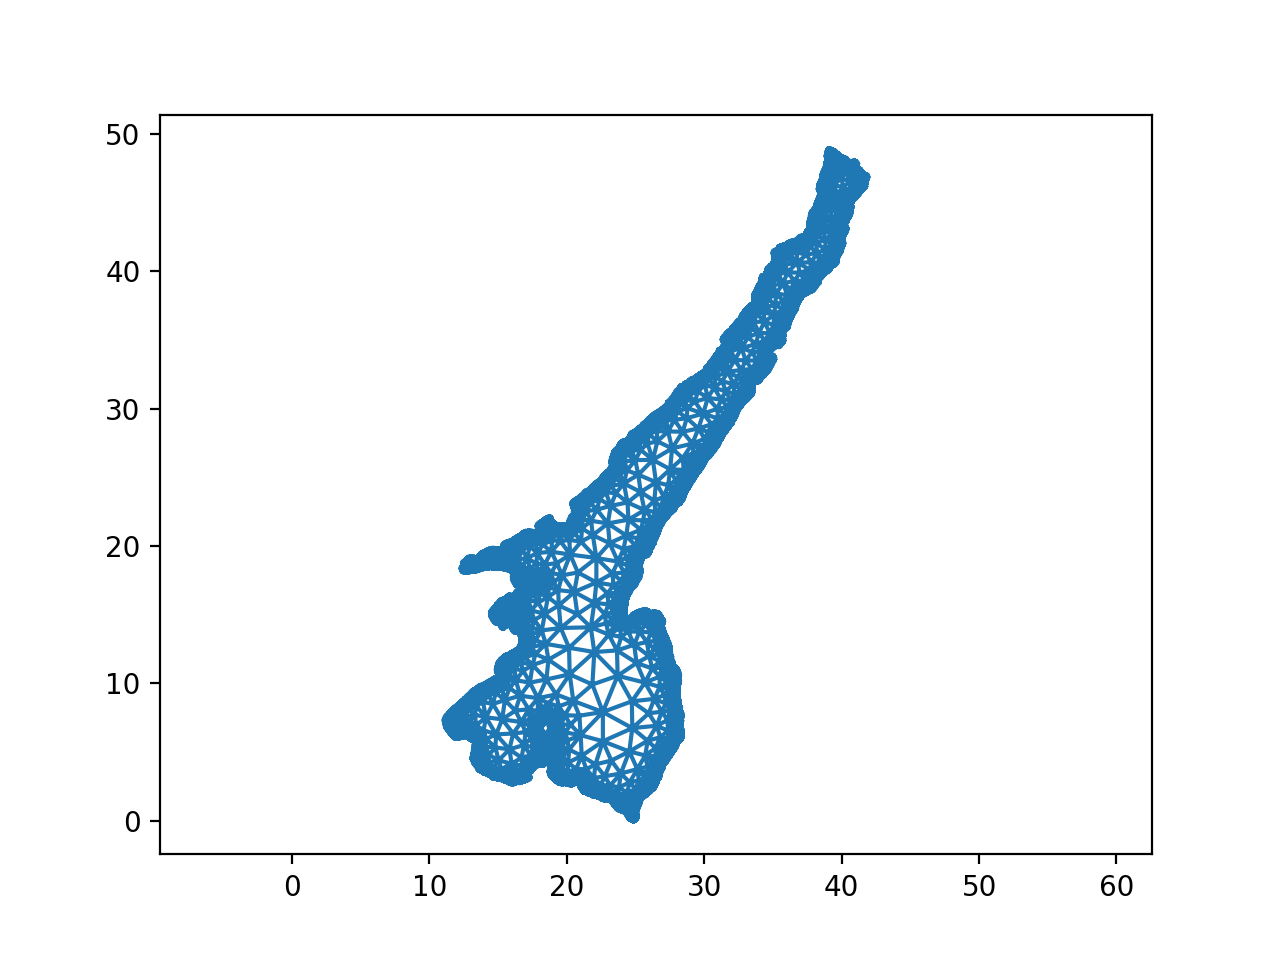

In [89]:
mesh = meshio.read('../mesh-files/gardasee.vtu')

Points = mesh.points[:,:2]  # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity

d  = CList.shape[1] - 1 # why didn't I simply ask for Points.shape[1]?

B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

print('Garda lake surface is  %3s km^2.' % ( np.sum( dtB ) / np.math.factorial( d ) ) )

fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

You know what could be real fun? Measure the length of its coastline! But there are some problems:

1. How do we do that? The idea is to find the induced mesh on the boundary (in our case a 1D mesh embedded in a 2D space) and then measure this mesh! 

2. How do we find the boundary mesh? The idea is to find EVERY edge in the mesh and then only keep the ones that are repeated just once as these must be on the boundary!

3. How do we find all the edges? Say that our triangle is ```[3,9,5]```. The edges we are searching for clearly are ```[3,9],[9,5],[3,5]```. But also ```[3,9],[5,9],[5,3]``` is a valid choice. There is a way to make order in our choice and preserve positivity of the determinant of the map for these edges. Imagine being an ant walking on the _reference element_: you are on the ```0``` vertex and counter-clockwise you read the edge in front of you as ```[1,2]```; then you move to the ```1``` vertex and counter-clockwise you read the edge in front of you as ```[2,0]```; keep going and you'll see ```[0,1]```. Therefore, for the triangle ```[3,9,5]``` a coherent choice of vertices are ```[9,5],[5,3],[3,9]```. Cool thing about this is that it generalise to higher-dimensional simplexes. For example in 3D the ant would list the following faces ```[[1,3,2],[2,3,0],[0,3,1],[1,2,0]]``` and preserve the determinant sign. Recursively one would find edges in a tetrahedralisation.

In [90]:
# this is the connectivity list of the edges of the reference 2D element
reference_EList = np.array([[1,2],[2,0],[0,1]])

# let's produce ALL edges in our mesh (alot of them are repeated twice cause they're busy kissing)
all_edges = CList[:,reference_EList.reshape(-1)].reshape((-1,d))

4. Ok so say we have all our beautiful edges. How do we find the repeated ones? There are two ways: a naive one (that I'll explain in details) and a shrewd one (that I'll only sketch). 

In [91]:
# NAIVE:
#
# Allocate a sparse matrix C. If an edge connects the vertex i with j (suppose wlog i<j) then C[i,j] += 1
# To find external edges we just seek for those entries of C equal exactly to 1.
#
# PROs:
# - very simple to understand
#
# CONs:
# - well, it doesn't work for faces in tetraedralisations: there is no such thing as sparse tensor
# - not perfectly efficient

import scipy.sparse as sps

# now we sort each edge list so that they are increasing array
all_edges = np.sort( all_edges, axis=1 )

i = all_edges[:,0]
j = all_edges[:,1]
a = np.full_like( i,1 )

Nv = Points.shape[0]

# wait a minute: which sparse data structure should I use? Idk let's discover it

import time

t = time.time()
C = sps.coo_array((a, (i, j)), shape=(Nv, Nv))
C.count_nonzero() # or it wont sum up entries
i,j,a = sps.find( C )
print('COO. Elapsed time %1.3f seconds.' % (time.time() - t))

t = time.time()
C = sps.csr_array((a, (i, j)), shape=(Nv, Nv))
i,j,a = sps.find( C )
print('CSR. Elapsed time %1.3f seconds.' % (time.time() - t))

t = time.time()
C = sps.lil_array(C)
C.count_nonzero() # to be sure
i,j,a = sps.find( C )
print('LIL. Elapsed time %1.3f seconds.' % (time.time() - t))


id = np.argwhere( a == 1 )
external_edges = np.hstack( (i[id],j[id]) )

# done :3

COO. Elapsed time 0.140 seconds.
CSR. Elapsed time 0.008 seconds.
LIL. Elapsed time 0.308 seconds.


In [92]:
B_   = ( Points[external_edges[:,1:]] - Points[external_edges[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
B_.shape

(10351, 2, 1)

Wait a minute! This is a stack of non square matrices!! How do we compute their determinant? 

We don't actually need to. In fact, when evaluating a multi integral by a change of coordinate with Jacobian say $J$, what we actually need is the square root of the metric tensor determinant, that is $\sqrt{\det(J^\top J)}$ that corresponds with $\det(J)$ when $J$ is a square matrix, therefore generalising this formula.


Reference 1: https://math.stackexchange.com/questions/4501583/is-there-a-name-for-det-jj-top1-2-where-j-is-a-non-square-jacobian-ma

Reference 2: https://www.physicsforums.com/threads/change-of-variable-in-integral-using-metric.637589/

Reference 3: https://en.wikipedia.org/wiki/Metric_tensor#Canonical_measure_and_volume_form

In [93]:
dtB_ = np.sqrt( np.linalg.det( B_.transpose( 0,2,1 ) @ B_ ) )

print('Garda lake coastlines length is  %3s km.' % ( np.sum( dtB_ ) / np.math.factorial( d-1 ) ) )

Garda lake coastlines length is  164.76034545898438 km.


In [85]:
# SHREWD
#
# Stack all edges/faces connectivity lists one on top of the other.
# Make sure to re-sort every row in ascending order.
# Now re-arrange this matrix rows so that they are in lexicographic ascending order
#     e.g. A = [ [ 1 5 9 ], [ 1 4 6 ] ] reordered is A = [ [ 1 4 6 ], [ 1 5 9 ] ]
# Diff this matrix along rows so that if two edges/faces were exactly the same you get a fully zero row.
# Keep only the non fully zeros rows not followed by fully zeros rows.
#
# PROs:
# - very efficient
# - it works in any dimension
#
# CONs:
# - students are not even close to understanding this

# these is the connectivity list of the edges of the reference 2D element
reference_EList = np.array([[1,2],[2,0],[0,1]])

# let's produce ALL edges in our mesh (alot of them are repeated twice cause they're busy kissing)
all_edges = CList[:,reference_EList.reshape(-1)].reshape((-1,d))

# now we sort each edge list so that they are increasing array
all_edges = np.sort( all_edges, axis=1 )

j = np.lexsort( np.flip( all_edges, axis = 1 ).T )

# now we diff all_edges[j,:] to find repeated edges (if any is nonzero then is not repeated)
# the 1st one cannot be repeated already, say the 2nd one is equal to the 1st then the 2nd is
# taken to be the repeated!
twins = np.hstack( ( True, np.any( np.diff( all_edges[ j,: ], axis = 0 ), axis = 1 ) ) )
outer = np.hstack( ( twins[:-1] * twins[1:], twins[-1] ) )

inv_j = np.empty_like( j )
inv_j[ j ] = np.arange( j.size )
outer = outer[ inv_j ]

# here we do differently from the MATLAB implementation  precisely for
# keeping the output the same through the code
id = np.flip( np.argwhere( outer.reshape( ( d + 1,-1 ), order = 'F' ) ), axis = 1 )

#self.meshEdgesTetFacesBelongTo = id[:,0]
external_edges = all_edges[ np.argwhere( outer ).reshape(-1), : ]


In [94]:
B_   = ( Points[external_edges[:,1:]] - Points[external_edges[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB_ = np.sqrt( np.linalg.det( B_.transpose( 0,2,1 ) @ B_ ) )

print('Garda lake coastline length is  %3s km.' % ( np.sum( dtB_ ) / np.math.factorial( d-1 ) ) )

Garda lake coastline length is  164.76034545898438 km.


### Example: measure torus external surface

Let's try with the torus now, we have $R = 0.6$ and $r = 0.2$, therefore the external surface is
$$
4\pi^2rR.
$$

In [100]:
mesh = meshio.read('../mesh-files/torus_hard.vtu')

Points = mesh.points        # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity

d  = CList.shape[1] - 1 # why didn't I simply ask for Points.shape[1]?

In [101]:
# can't use naive formula :C

# these is the connectivity list of the edges of the reference 2D element
reference_FList = np.array([[1,3,2],[2,3,0],[0,3,1],[1,2,0]])

# let's produce ALL edges in our mesh (alot of them are repeated twice cause they're busy kissing)
all_faces = CList[:,reference_FList.reshape(-1)].reshape((-1,d))

# now we sort each edge list so that they are increasing array
all_faces = np.sort( all_faces, axis=1 )

j = np.lexsort( np.flip( all_faces, axis = 1 ).T )

# now we diff all_faces[j,:] to find repeated faces (if any is nonzero then is not repeated)
# the 1st one cannot be repeated already, say the 2nd one is equal to the 1st then the 2nd is
# taken to be the repeated!
twins = np.hstack( ( True, np.any( np.diff( all_faces[ j,: ], axis = 0 ), axis = 1 ) ) )
outer = np.hstack( ( twins[:-1] * twins[1:], twins[-1] ) )

inv_j = np.empty_like( j )
inv_j[ j ] = np.arange( j.size )
outer = outer[ inv_j ]

# here we do differently from the MATLAB implementation  precisely for
# keeping the output the same through the code
id = np.flip( np.argwhere( outer.reshape( ( d + 1,-1 ), order = 'F' ) ), axis = 1 )

#self.meshEdgesTetFacesBelongTo = id[:,0]
external_faces = all_faces[ np.argwhere( outer ).reshape(-1), : ]



In [103]:
B_ = ( Points[external_faces[:,1:]] - Points[external_faces[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
print( B_.shape )
dtB_ = np.sqrt( np.linalg.det( B_.transpose( 0,2,1 ) @ B_ ) )


R = 0.6
r = 0.2
print('Volume computed using meshing %0.8e.' % ( np.sum( dtB_ ) / np.math.factorial( d - 1 ) ) )
print('Volume computed analytically  %0.8e.' % ( 4 * np.pi ** 2 * r * R ) )

(20000, 3, 2)
Volume computed using meshing 4.73468304e+00.
Volume computed analytically  4.73741011e+00.
